In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from os.path import join, isfile
import optuna
import scipy
import pickle
import json
import ili
from ili.utils.ndes_pt import LampeEnsemble
from scipy.stats import qmc
import sbibm
from sbibm.tasks.gaussian_linear.task import GaussianLinear
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## TailedNormal Distribution Class

In [2]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [3]:
def sample_uniform_lhs(n_samples, dim, low=-1.0, high=1.0, device=device):
    """Generate uniform samples using Latin Hypercube Sampling"""
    sampler = qmc.LatinHypercube(d=dim, seed=42)
    u_samples = sampler.random(n_samples)
    # Transform from [0,1]^d to [low,high]^d
    samples = low + (high - low) * u_samples
    return torch.tensor(samples, dtype=torch.float32, device=device)

## STEP 1 - Generate Training Data and Setup Optuna Studies

In [4]:
n_simulations = 10000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

In [5]:
# Create the uniform proposal distribution
proposal_uniform = ili.utils.Uniform(
    low=[param_1_range[0], param_2_range[0]], 
    high=[param_1_range[1], param_2_range[1]], 
    device=device)

# Create the TailedNormal distribution
proposal_tailed = TailedNormal(
    a = torch.tensor([param_1_range[0], param_2_range[0]], dtype=torch.float32),
    b = torch.tensor([param_1_range[1], param_2_range[1]], dtype=torch.float32),
    sigma = torch.tensor([sigmas[0], sigmas[1]], dtype=torch.float32),
)

# Sample from proposals using LHS
theta_uniform = sample_uniform_lhs(n_simulations, dim=2, low=-1.0, high=1.0, device=device)
theta_tailed = proposal_tailed.sample_lhs(n_simulations)

# Run simulations for each parameter set
x_uniform = simulator(theta_uniform)
x_tailed = simulator(theta_tailed)

# Print parameter ranges
print("Uniform proposal parameter range: \n"
      f"\tParam1={theta_uniform[:, 0].min():.3f}-{theta_uniform[:, 0].max():.3f},\n"
      f"\tParam2={theta_uniform[:, 1].min():.3f}-{theta_uniform[:, 1].max():.3f}")
print("TailedNormal proposal parameter range: \n"
      f"\tParam1={theta_tailed[:, 0].min():.3f}-{theta_tailed[:, 0].max():.3f},\n"
      f"\tParam2={theta_tailed[:, 1].min():.3f}-{theta_tailed[:, 1].max():.3f}")

Uniform proposal parameter range: 
	Param1=-1.000-1.000,
	Param2=-1.000-1.000
TailedNormal proposal parameter range: 
	Param1=-1.722-1.779,
	Param2=-1.742-1.698


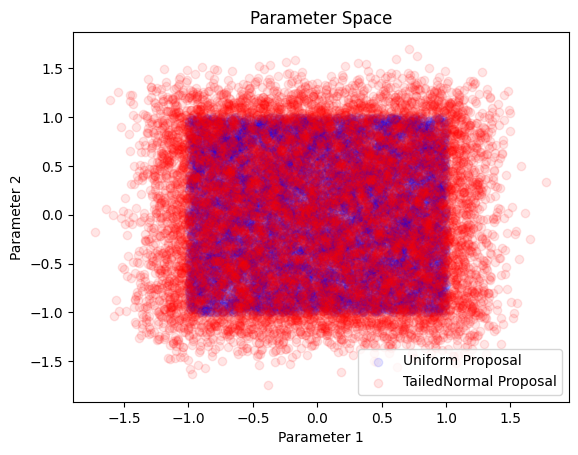

In [7]:
plt.scatter(theta_uniform[:, 0].cpu(), theta_uniform[:, 1].cpu(),
            c='blue', label='Uniform Proposal', alpha=0.1)
plt.scatter(theta_tailed[:, 0].cpu(), theta_tailed[:, 1].cpu(),
            c='red', label='TailedNormal Proposal', alpha=0.1)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Parameter Space')
plt.legend()
plt.show()

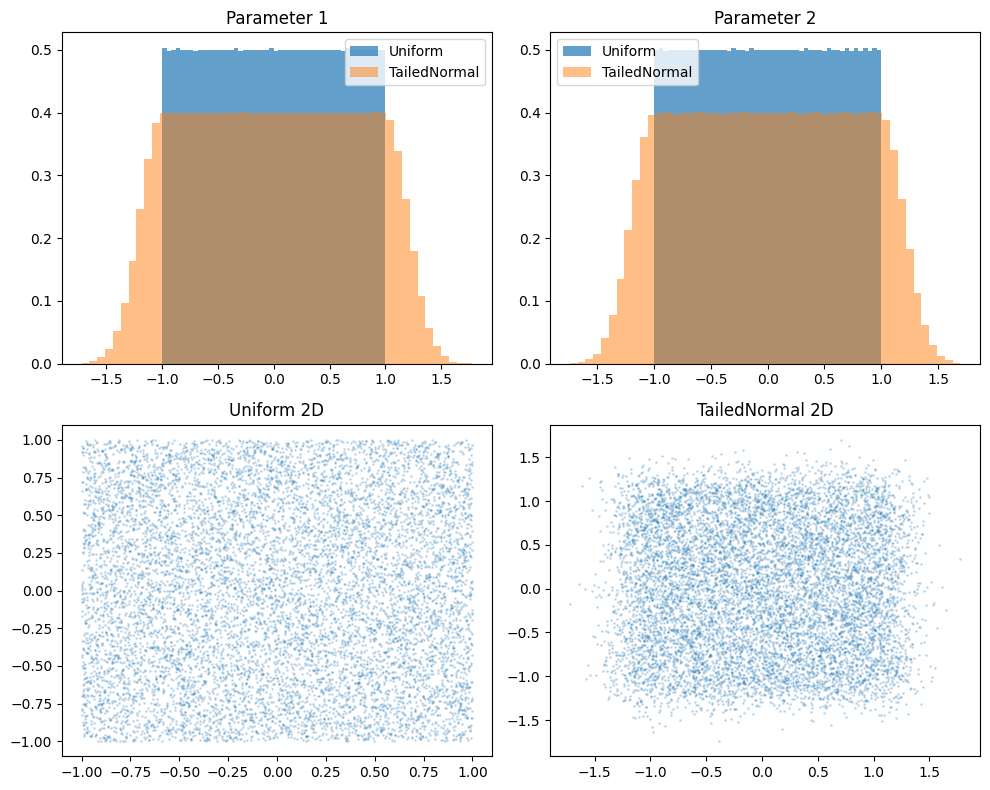

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Parameter 1
axes[0, 0].hist(theta_uniform[:, 0], bins=50, alpha=0.7,
                label='Uniform', density=True)
axes[0, 0].hist(theta_tailed[:, 0], bins=50, alpha=0.5,
                label='TailedNormal', density=True)
axes[0, 0].set_title('Parameter 1')
axes[0, 0].legend()

# Parameter 2
axes[0, 1].hist(theta_uniform[:, 1], bins=50, alpha=0.7,
                label='Uniform', density=True)
axes[0, 1].hist(theta_tailed[:, 1], bins=50, alpha=0.5,
                label='TailedNormal', density=True)
axes[0, 1].set_title('Parameter 2')
axes[0, 1].legend()

# 2D scatter plots
axes[1, 0].scatter(theta_uniform[:, 0], theta_uniform[:, 1], alpha=0.2, s=1)
axes[1, 0].set_title('Uniform 2D')

axes[1, 1].scatter(theta_tailed[:, 0], theta_tailed[:, 1], alpha=0.2, s=1)
axes[1, 1].set_title('TailedNormal 2D')

plt.tight_layout()
plt.show()

In [9]:
# Split training/test
frac_train = 0.8
seed = 42
np.random.seed(seed)
shuffled_indices = np.random.permutation(n_simulations)
split_idx = int(frac_train * n_simulations)

# Uniform
theta_uniform_train = theta_uniform[shuffled_indices[:split_idx]]
x_uniform_train = x_uniform[shuffled_indices[:split_idx]]
theta_uniform_test = theta_uniform[shuffled_indices[split_idx:]]
x_uniform_test = x_uniform[shuffled_indices[split_idx:]]

# TailedNormal
theta_tailed_train = theta_tailed[shuffled_indices[:split_idx]]
x_tailed_train = x_tailed[shuffled_indices[:split_idx]]
theta_tailed_test = theta_tailed[shuffled_indices[split_idx:]]
x_tailed_test = x_tailed[shuffled_indices[split_idx:]]

In [10]:
# SAVE THE DATA AND CREATE OPTUNA STUDIES
model_library = 'toy-2-dim-models'
os.makedirs(model_library, exist_ok=True)


def setup_optuna(exp_path, name, n_startup_trials):
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=n_startup_trials,
        multivariate=True,
        constant_liar=True,
    )
    study = optuna.create_study(
        sampler=sampler,
        direction="maximize",
        storage='sqlite:///'+join(exp_path, 'optuna_study.db'),
        study_name=name,
        load_if_exists=True
    )
    return study


# Uniform NPE
model_dir = join(model_library, 'uniform_toy')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta_train.npy'), theta_uniform_train.numpy())
np.save(join(model_dir, 'x_train.npy'), x_uniform_train.numpy())
np.save(join(model_dir, 'theta_test.npy'), theta_uniform_test.numpy())
np.save(join(model_dir, 'x_test.npy'), x_uniform_test.numpy())
_ = setup_optuna(model_dir, 'uniform_toy', n_startup_trials=20)

# TailedNormal NPE
model_dir = join(model_library, 'tailed_toy')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta_train.npy'), theta_tailed_train.numpy())
np.save(join(model_dir, 'x_train.npy'), x_tailed_train.numpy())
np.save(join(model_dir, 'theta_test.npy'), theta_tailed_test.numpy())
np.save(join(model_dir, 'x_test.npy'), x_tailed_test.numpy())
_ = setup_optuna(model_dir, 'tailed_toy', n_startup_trials=20)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-17 15:40:49,615] A new study created in RDB with name: uniform_toy
[I 2025-11-17 15:40:50,089] A new study created in RDB with name: tailed_toy


## Step 2 - Run Optuna Experiments

run `python scripts/run_optuna_toy.py` (you may need to update this script for the toy problem)

## Step 3 - Gather results and save final model

In [ ]:
model_library = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/toy-2-dim-models'
model_name = 'tailed_toy'  # 'tailed_toy' or 'uniform_toy'

model_dir = join(model_library, model_name)
net_dir = join(model_dir, 'nets')

In [ ]:
# Load optuna database and plot study results
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_slice

study = optuna.load_study(
    study_name=model_name,
    storage='sqlite:///'+join(model_dir, 'optuna_study.db')
)

plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
# Collect log probabilities from all experiments

net_paths = os.listdir(net_dir)

log_probs = []
for dname in net_paths:
    exp_dir = join(net_dir, dname)
    log_prob_file = join(exp_dir, 'log_prob_test.txt')
    if os.path.exists(log_prob_file):
        with open(log_prob_file, 'r') as f:
            log_prob = float(f.read().strip())
        log_probs.append(log_prob)
    else:
        log_probs.append(-np.inf)
log_probs = np.array(log_probs)

print(f"Collected log probabilities from {len(log_probs)} experiments.")

In [ ]:
from toolbox.utils import load_posterior

Nnets = 10  # number of top nets to ensemble
weighted = True  # whether to weight by log prob

top_nets = np.argsort(log_probs)[::-1][:Nnets]
print(f'Selected nets: {[net_paths[i] for i in top_nets]}')

ensemble_list = []
for i in top_nets:
    model_path = join(net_dir, net_paths[i], 'posterior.pkl')
    pi = load_posterior(model_path, 'cpu')
    ensemble_list.append(pi.posteriors[0])

if weighted:
    ensemble_logprobs = log_probs[top_nets]
    weights = scipy.special.softmax(ensemble_logprobs)
    weights = torch.Tensor(weights)
else:
    weights = torch.ones(len(top_nets)) / len(top_nets)

ensemble = LampeEnsemble(
    posteriors=ensemble_list,
    weights=weights
)

# save ensemble
with open(join(model_dir, 'ensemble.pkl'), "wb") as handle:
    pickle.dump(ensemble, handle)

In [ ]:
# plot all the losses of the top nets
f, ax = plt.subplots(figsize=(8, 6))
for i in top_nets:
    loss_file = join(net_dir, net_paths[i], 'summary.json')
    with open(loss_file, 'r') as f:
        summary = json.load(f)
    ax.plot(summary[0]['validation_log_probs'], label=f'Net {i}')
ax.set(xlabel='Epoch', ylabel='Validation Log Probability')
ax.legend()

In [ ]:
# Test the ensemble on a sample observation
ind = 12
x0, y0 = x_uniform_test[ind], theta_uniform_test[ind]

out = ensemble.sample((1000,), x0).cpu().numpy()
f, axs = plt.subplots(2, 1, figsize=(5, 7))
ax = axs[0]
ax.hist(out[:, 0], bins=30, density=True)
ax.axvline(y0[0].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 1')

ax = axs[1]
ax.hist(out[:, 1], bins=30, density=True)
ax.axvline(y0[1].cpu(), color='red', linestyle='--', label='True value')
ax.set_xlabel('Parameter 2')
ax.legend()

In [ ]:
# Plot single posterior
metric = ili.validation.metrics.PlotSinglePosterior(
    num_samples=1000, labels=range(2),
    sample_method='direct')
metric(ensemble, x_obs=x0, theta_fid=y0)